# Made by Jorge Camilo Colmenares Santos

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec  1 21:57:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! pip install keras-tuner -q

In [ ]:
#First conect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install unrar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The source of the data is:  https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database?datasetId=576013&sortBy=dateRun&tab=bookmarked 

Data is loaded from google drive

In [ ]:
!unrar x '/content/drive/MyDrive/proyecto_IA_medicos/train.rar'

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Extracting  train/Normal/Normal-6203.png                                  72%  OK 
Extracting  train/Normal/Normal-6204.png                                  72%  OK 
Extracting  train/Normal/Normal-6206.png                                  72%  OK 
Extracting  train/Normal/Normal-6207.png                                  72%  OK 
Extracting  train/Normal/Normal-6208.png                                  72%  OK 
Extracting  train/Normal/Normal-6209.png                                  72%  OK 
Extracting  train/Normal/Normal-621.png                                   72%  OK 
Extracting  train/Normal/Normal-6211.png                                  72%  OK 
Extracting  train/Normal/Normal-6212.png                                  72%  OK 
Extracting  train/Normal/Normal-6213.png                                  72%  OK 
Extracting  t

In [ ]:
!unrar x '/content/drive/MyDrive/proyecto_IA_medicos/test.rar'

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import numpy as np
import random
import pandas as pd
import tensorflow as tf
import keras_tuner
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Input, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.layers import RandomFlip, RandomRotation, Resizing, RandomZoom
from tensorflow.image import  adjust_brightness, adjust_saturation
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
IMG_SIZE = (224,224)
def get_imageDataset(directory,subset=None,batch_size=32,seed=123,shuffle=None):
  return image_dataset_from_directory(
      directory,
      image_size=IMG_SIZE,
      batch_size=batch_size,
      shuffle=shuffle,
      labels='inferred',
      label_mode='categorical',
      color_mode = 'rgb',
      seed=seed,
      validation_split=0.10,
      subset=subset
  )

In [ ]:
train_ds = get_imageDataset('/content/train',subset='training',shuffle=True)
val_ds   = get_imageDataset('/content/train',subset='validation',shuffle=True)

Found 19045 files belonging to 4 classes.
Using 17141 files for training.
Found 19045 files belonging to 4 classes.
Using 1904 files for validation.


In [ ]:
IMG_SIZE = (224,224)
def get_imageDataset_test(directory,subset=None,batch_size=1,seed=123,shuffle=None):
  return image_dataset_from_directory(
      directory,
      image_size=IMG_SIZE,
      batch_size=batch_size,
      shuffle=shuffle,
      labels='inferred',
      label_mode='categorical',
      color_mode = 'rgb',
      seed=seed,
      
  )

data loaded for the test set

In [ ]:
test_ds = get_imageDataset_test('/content/test',subset='training')

Found 2120 files belonging to 4 classes.


In [ ]:
class_names = train_ds.class_names
num_class   = len(class_names)
print(class_names)

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


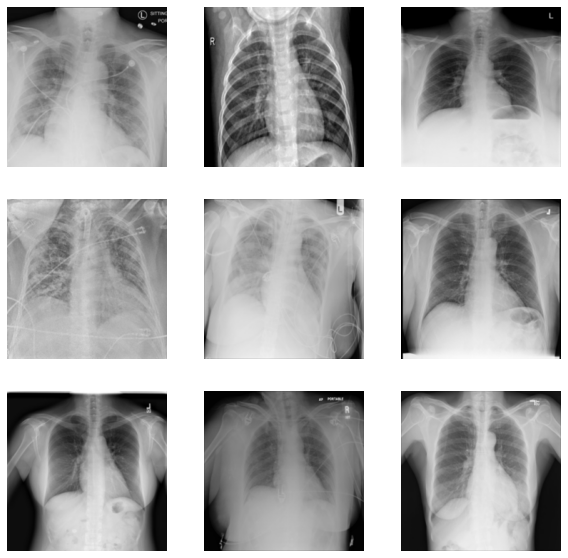

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 4)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Functions for data augmentation

In [ ]:
def random_flip_on_probability(image, probability= 0.5):
    if random.random() < probability:
      return tf.image.random_flip_left_right(image)
    return image

def random_adjust_brightness_probability(image, probability= 0.5):
    if random.random() < probability:
      return tf.image.adjust_brightness(image, 0.4)
    return image

def random_adjust_saturation_probability(image, probability= 0.5):
    if random.random() < probability:
      return tf.image.adjust_saturation(image, 3)
    return image

Data augmentation


In [ ]:
data_aug = Sequential([
    Resizing(224,224,interpolation='gaussian'),
    RandomRotation(0.2),
    RandomZoom(0.1),
    tf.keras.layers.Lambda(random_flip_on_probability),
    tf.keras.layers.Lambda(random_adjust_brightness_probability),
    tf.keras.layers.Lambda(random_adjust_saturation_probability)
    
])

In [ ]:
#We import and use the preprocees_input that was used in the training of ResNet50V2 model as a new Keras layer
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess

preprocess_layer = resnet_preprocess

IMG_SHAPE = IMG_SIZE+(3,)
base_model = ResNet50V2(
  input_shape=(IMG_SHAPE),
  include_top=False,
  weights='imagenet'
)

#Freeze the layers of the base model
base_model.trainable = False
#summary
base_model.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [ ]:
#We import and use the preprocees_input that was used in the training of VGG19 model as a new Keras layer
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg_preprocess

preprocess_layer = vgg_preprocess

IMG_SHAPE = IMG_SIZE+(3,)
base_model = VGG19(
  input_shape=(IMG_SHAPE),
  include_top=False,
  weights='imagenet'
)
#Freeze the layers of the base model
base_model.trainable = False
#summary
base_model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

These hyperparameters are in another notebook attached in this repository which were discovered with keras turner.

In [ ]:
#best parameters
'''
Trial summary
Hyperparameters:
num_dense_laye: 2
units_0: 256
dpr_0: 0.2
lr: 0.0005636780669065919
units_1: 128
dpr_1: 0.2
Score: 0.833175778388977
'''

I create the model based on the above hyperparameters

In [ ]:
inputs = Input(shape=(None,None,3))
x = data_aug(inputs)
x = preprocess_layer(x)
x = base_model(x,training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(256,activation='relu',kernel_regularizer='l2',kernel_initializer='he_normal')(x)
x = Dropout(0.2)(x)
x = Dense(128,activation='relu',kernel_regularizer='l2',kernel_initializer='he_normal')(x)
x = Dropout(0.2)(x)
out = Dense(num_class,activation='softmax')(x)

best_model = Model(inputs=inputs,outputs=out)

metricas = [
            tf.keras.metrics.CategoricalAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
  ]

best_model.compile(
    optimizer=Adam(5e-4),
    loss='categorical_crossentropy',
    metrics=metricas
)
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

I define two more callbacks, one to decrease the learning rate during the training and another one to save the best weights.

In [ ]:
def scheduler(epoch,lr):
  if epoch<10:
    return lr
  else:
    return lr*tf.math.exp(-0.1)

def checkpoint_best():
  path = 'checkpoint_best/checkpoint'
  checkp = ModelCheckpoint(
      filepath=path,
      save_weights_only=True,
      save_freq='epoch',
      monitor='val_categorical_accuracy',
      save_best_only=True,
      verbose=1
  )
  return checkp

history = best_model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=20,
      callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler),checkpoint_best()],
      verbose=1
)

Epoch 1/20
536/536 [==============================] - ETA: 0s - loss: 5.4761 - categorical_accuracy: 0.6679 - precision: 0.7058 - recall: 0.6066
Epoch 1: val_categorical_accuracy improved from -inf to 0.77363, saving model to checkpoint_best/checkpoint
536/536 [==============================] - 168s 292ms/step - loss: 5.4761 - categorical_accuracy: 0.6679 - precision: 0.7058 - recall: 0.6066 - val_loss: 3.1807 - val_categorical_accuracy: 0.7736 - val_precision: 0.8306 - val_recall: 0.7106 - lr: 5.0000e-04
Epoch 2/20
536/536 [==============================] - ETA: 0s - loss: 2.3418 - categorical_accuracy: 0.7558 - precision: 0.7939 - recall: 0.7085
Epoch 2: val_categorical_accuracy improved from 0.77363 to 0.79464, saving model to checkpoint_best/checkpoint
536/536 [==============================] - 139s 260ms/step - loss: 2.3418 - categorical_accuracy: 0.7558 - precision: 0.7939 - recall: 0.7085 - val_loss: 1.6531 - val_categorical_accuracy: 0.7946 - val_precision: 0.8325 - val_recall:

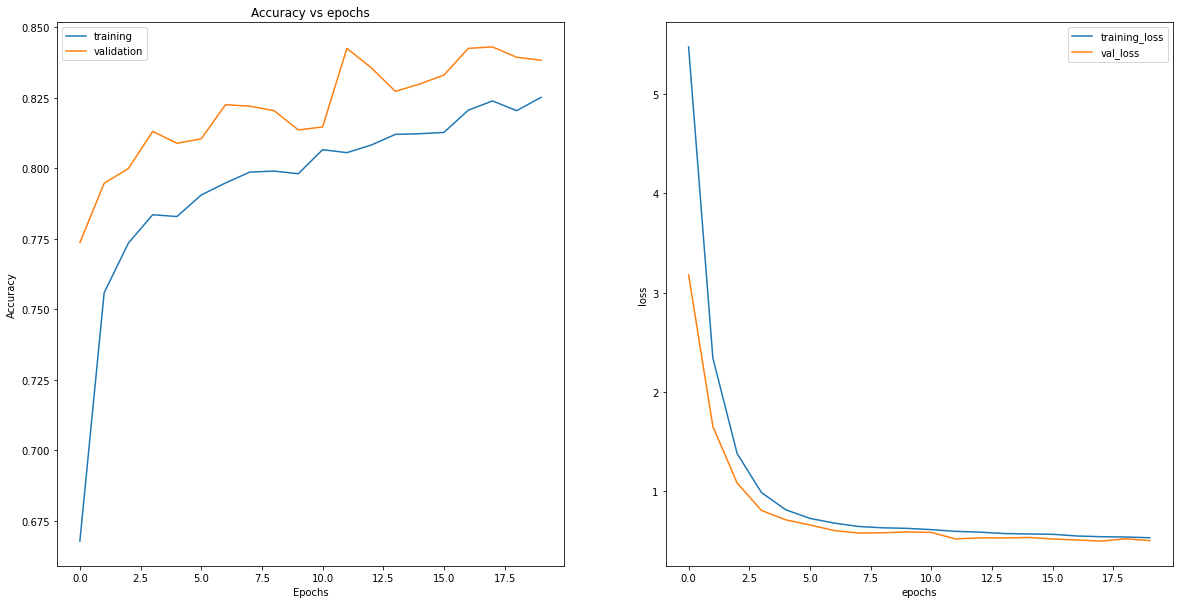

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(20,10))
plt.subplot(121)
try:
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
except KeyError:
  plt.plot(history.history['acc_categorical_'])
  plt.plot(history.history['val_categorical_acc'])
plt.title('Accuracy vs epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['training_loss','val_loss'])
plt.show()

I do load the best weights of the model

In [ ]:
best_model.load_weights('/content/checkpoint_best/checkpoint')

##Fine tuning

We unfreeze the layers of the base model

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers  ", len(base_model.layers))

Number of layers   22


we refreeze some layers of the trained model and leave only a few thawed ones, being careful not to leave too many as there is a risk of causing overfitting, also this part is to do several tests

In [ ]:
fine_tune_at = 20

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
metricas = [
            tf.keras.metrics.CategoricalAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
  ]

best_model.compile(
    optimizer=Adam(5e-4),
    loss='categorical_crossentropy',
    metrics=metricas
)

In [ ]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

We retrained the model again

In [ ]:
def checkpoint_best_ft():
  path = 'checkpoint_best_ft/checkpoint'
  checkp = ModelCheckpoint(
      filepath=path,
      save_weights_only=True,
      save_freq='epoch',
      monitor='val_categorical_accuracy',
      save_best_only=True,
      verbose=1
  )
  return checkp
def fine_scheduler(epoch,lr):
  if epoch<1:
    return lr
  else:
    return lr*tf.math.exp(-0.1)

ini_epochs = len(history.epoch)
fine_tun_epochs = 5
total_epochs = ini_epochs + fine_tun_epochs

history_fine = best_model.fit(
      train_ds,
      validation_data=val_ds,
      initial_epoch=history.epoch[-1],
      epochs=total_epochs,
      callbacks=[tf.keras.callbacks.LearningRateScheduler(fine_scheduler),checkpoint_best_ft()],
      verbose=1
)

Epoch 20/25
536/536 [==============================] - ETA: 0s - loss: 0.5375 - categorical_accuracy: 0.8221 - precision_1: 0.8390 - recall_1: 0.7969
Epoch 20: val_categorical_accuracy improved from -inf to 0.86082, saving model to checkpoint_best_ft/checkpoint
536/536 [==============================] - 138s 253ms/step - loss: 0.5375 - categorical_accuracy: 0.8221 - precision_1: 0.8390 - recall_1: 0.7969 - val_loss: 0.4372 - val_categorical_accuracy: 0.8608 - val_precision_1: 0.8645 - val_recall_1: 0.8545 - lr: 4.5242e-04
Epoch 21/25
536/536 [==============================] - ETA: 0s - loss: 0.4152 - categorical_accuracy: 0.8679 - precision_1: 0.8797 - recall_1: 0.8543
Epoch 21: val_categorical_accuracy improved from 0.86082 to 0.88078, saving model to checkpoint_best_ft/checkpoint
536/536 [==============================] - 138s 258ms/step - loss: 0.4152 - categorical_accuracy: 0.8679 - precision_1: 0.8797 - recall_1: 0.8543 - val_loss: 0.3671 - val_categorical_accuracy: 0.8808 - val_p

In [ ]:
acc += history_fine.history['categorical_accuracy']
val_acc += history_fine.history['val_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

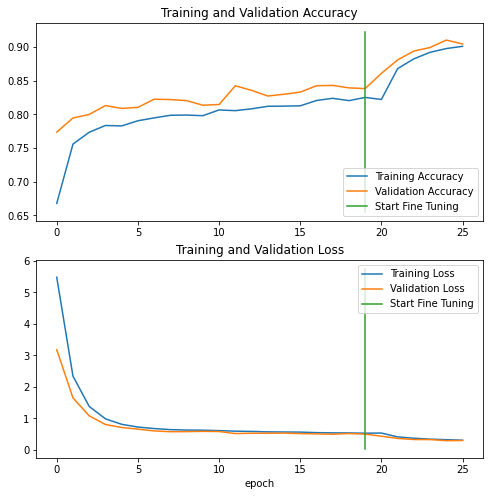

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([ini_epochs-1,ini_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([ini_epochs-1,ini_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Save the model version 001



In [ ]:
version = '001'
tf.saved_model.save(best_model, f'/content/drive/MyDrive/proyecto_IA_medicos/ChestRay/{version}')

I do load the data  test set

In [ ]:
files = 2120
labels = []
for i in test_ds.take(files):

  labels.append(i[1][0].numpy())


predictions = best_model.predict(test_ds,steps=files)
y_pred      = [np.argmax(x) for x in predictions]
y_true      = [np.argmax(y) for y in labels]

2120/2120 [==============================] - 30s 14ms/step


In [ ]:
len(y_true)

2120

F1-score

In [ ]:
f1_score(y_true,y_pred,average='micro')

0.9004716981132075

In [ ]:
f1_score(y_true,y_pred,average='macro')

0.895722329309784

confussion matrix

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

In [ ]:
classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

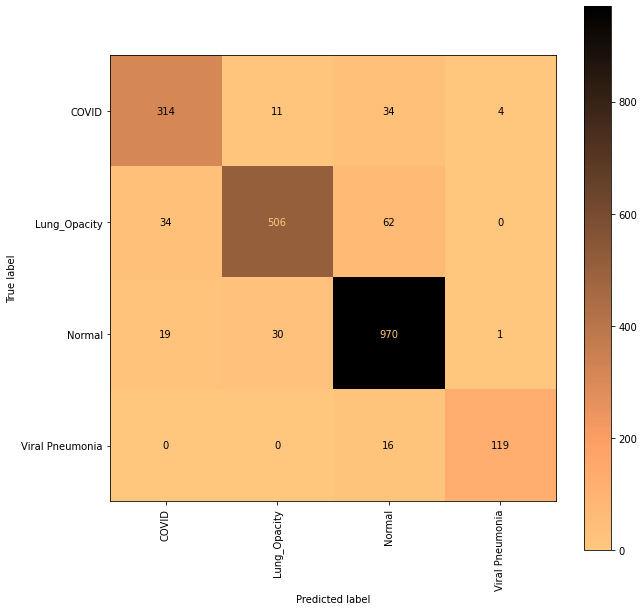

In [ ]:
cm   = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels= classes)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, xticks_rotation='vertical', cmap='copper_r')

plt.show()